<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Прогнозирование стоимости автомобиля по характеристикам

* Работу выполнили Людмила Григорьева и Юлия Гиль
* Группа DSPR-28

# Содержание

1. [IMPORT, FUNCTIONS, SETUP](#1)
2. [DDATA & PRELIMINARY ANALYSIS](#2)
3. [EDA](#3) 
4. [NAÏVE MODEL](#4)
5. [MODEL IMPROVEMENTS](#5)
    * 
6. [SUBMISSION](#6)
7. [SUMMARY](#7)

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

<a id="1"></a>
# 1. Import, Functions, Setup

In [1]:
!pip3 install catboost

In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np  
import pandas as pd 
import sys
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.10 (default, May 19 2021, 11:01:55) 
Numpy        : 1.20.3


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

## Functions

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Setup

In [8]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

## Data Storage

In [9]:
!ls '../input'

ls: ../input: No such file or directory


In [10]:
# Подключение с Kaggle
""" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"""

" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели\ntest = pd.read_csv(DIR_TEST+'test.csv')\nsample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"

In [11]:
# Подключение при работе в Jupyter/Github
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [12]:
train.head(5)

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль  Состояние Владельцы        ПТС Таможня  \
0          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
1          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
2          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
3          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
4          MECHANICAL  ...  LEFT        NaN       3.0  DUPLICATE    True   

  Владение     price            start_date  hidden model  
0      NaN  200000.0  2019-10-03T08:09:11Z     NaN   100  
1      NaN   60000.0  2020-09-06T06:49:40Z     NaN   100  
2      NaN   99000.0  2020-09-02T14:04:21Z     NaN   100  
3      NaN   65000.0  2020-08-23T17:40:09Z     NaN   100  
4      NaN  100000.0  2020-09-08T09:22:07Z     NaN   100  

[5 rows x 26 columns]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [14]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Web Data Extracting (auto.ru)

Посмотрим на список колонок, которые есть в test, но нет в подключенном train.

In [16]:
# Список колонок, которых нет в train
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

# Посмотрим на данные в этих колонках
test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['priceCurrency', 'vendor', 'parsing_unixtime', 'car_url', 'sell_id', 'model_name', 'super_gen', 'complectation_dict', 'model_info', 'image', 'equipment_dict']


priceCurrency    vendor  parsing_unixtime  \
20057           RUB  JAPANESE        1603290321   
21395           RUB  JAPANESE        1603295367   
22547           RUB  JAPANESE        1603299768   

                                                 car_url     sell_id  \
20057  https://auto.ru/cars/used/sale/toyota/camry/11...  1101196750   
21395  https://auto.ru/cars/used/sale/toyota/land_cru...  1101163600   
22547  https://auto.ru/cars/used/sale/lexus/gs/109400...  1094006272   

         model_name                                          super_gen  \
20057         CAMRY  {"id":"20465002","displacement":2959,"engine_t...   
21395  LAND_CRUISER  {"id":"7953785","displacement":4461,"engine_ty...   
22547            GS  {"id":"7919399","name":"250","nameplate":"250"...   

                                      complectation_dict  \
20057                                                NaN   
21395  {"id":"7953884","name":"Люкс 7 мест","availabl...   
22547                                                NaN   

                                              model_info  \
20057  {"code":"CAMRY","name":"Camry","ru_name":"Камр...   
21395  {"code":"LAND_CRUISER","name":"Land Cruiser","...   
22547  {"code":"GS","name":"GS","ru_name":"GS","morph...   

                                                   image  \
20057  https://autoru.naydex.net/LxPU17803/f5b8d77S/u...   
21395  https://avatars.mds.yandex.net/get-autoru-vos/...   
22547  https://autoru.naydex.net/imflT9272/520f62I9/2...   

                                          equipment_dict  
20057                                                NaN  
21395  {"cruise-control":true,"tinted-glass":true,"es...  
22547                                                NaN

In [17]:
# Посмотрим на колическтво уникальных значений
for item in dif_list:
    print(item, test[item].nunique())

priceCurrency 1
vendor 2
parsing_unixtime 34686
car_url 34686
sell_id 34686
model_name 544
super_gen 5890
complectation_dict 2364
model_info 954
image 34557
equipment_dict 23705


Выводы:
1. Из информации car_url видим, что данные собирались с сайта auto.ru, будем парсить данные оттуда
2. Следующие поля из test можно не парсить и удалить далее при анализе, т.к. они уникальны для каждой записи: car_url и priceCurrency, т.к. всего одно значение (RUB). Car_url оставим, чтоб можно было посмотреть информацию о машине.
3. Ограничимся для начала двумя вендорами: EUROPEAN, JAPANESE
4. Цену автомобиля собираем в RUB
5. Собираем информацию по полям: 'bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict','fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name','name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency','productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration','vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС','Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'price'

# 3. EDA & Basic Data Cleaning

Проведем анализ данных, сделаем базовый препроцессинг данных.

### 3.1 Переименуем колонки с кириллицы на латиницу

In [18]:
# Переименуем test  колонки
test.rename(columns={"Привод": "drivetrain",
                     "Руль": "driveSide",
                     "Состояние": "condition",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Таможня": "customs",
                     "Владение": "ownershipTime"}, inplace=True)

# Переименуем train  колонки
train.rename(columns={"Привод": "drivetrain",
                      "Руль": "driveSide",
                      "Состояние": "condition",
                      "Владельцы": "ownersCount",
                      "ПТС": "tcp",
                      "Таможня": "customs",
                      "Владение": "ownershipTime"}, inplace=True)

### 3.2 Предварительный анализ test данных

Посмотрим на данные в test, которые нужно предсказывать, на особенности данных.

In [70]:
# ProfileReport(test, title="Pandas Profiling Report for Test Dataset")

Summarize dataset:   0%|          | 0/47 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Выводы: во время последующего сбора данных и анализа обратить внимание на:
1. Есть пропуски в test данных - нужно попробовать заполнить
2. Представлено всего 12 брендов автомобилей
3. Признаки, которые выглядят бесполезными для моделирования - car_url (уникальный для каждой записи), priceCurrencly (одинаковый у всех)
4. Необходимо разобраться с признаками complectation_dict, description, equipment_dict, model_info, super_gen - посмотреть, можно ли извлечь доп. признаки
5. Condition - у всех "хорошее состояние", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.
6. Customs - у всех "растоможетн", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.

In [84]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'ownersCount', 'ownershipTime', 'tcp',
       'drivetrain', 'driveSide', 'condition', 'customs', 'train', 'price'],
      dtype='object')

### 3.3 Сравним типы данных в test и train

Найдем расхождения в типах данных для train и test, устраним их до анализа данных.

In [19]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [20]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки ownersCount: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки customs: для train - <class 'numpy.bool_'>, для test - <class 'str'>
	- колонки condition: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>


**ownersCount**

Количество владельцев автомобиля (1 - один, 2 - два, 3 - 3 и более).

In [21]:
print("Уникальные значения для train", train.ownersCount.unique())
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для train [ 3.  1.  2. nan]
Уникальные значения для test ['3 или более' '1\xa0владелец' '2\xa0владельца']


Преобразуем значения test в числовые (float).

In [22]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3., "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [23]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для test [3. 1. 2.]


**enginePower**

Мощность л.с.

In [24]:
print("Пример значения для train", train.enginePower.sample(1).values)
print("Пример значения для test", test.enginePower.sample(1).values)

Пример значения для train [140.]
Пример значения для test ['143 N12']


Преобразуем значения test в числовые (float).

In [25]:
test.enginePower.nunique()

315

In [26]:
# Преобразовываем значения столбца, избавляемся от постфика N12
test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split(" ")[0]))

In [27]:
# Посмотрим на результат преобразования
print("Пример значения для test", test.enginePower.sample(1).values)

Пример значения для test [184.]


**numberOfDoors**

Количество дверей.

In [28]:
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Уникальные значения для train [ 4.  5.  3.  2. nan  0.]
Уникальные значения для test [5 4 2 3 0]


Значения аналогичны, целые числа, приведем в train к int.

In [29]:
# Конвертируем в int
train['numberOfDoors'] = train['numberOfDoors'].astype('Int64')

**customs**

Информация, растоможен ли автомобиль: 0 - не растоможен, 1 - растоможен.

In [30]:
print("Уникальные значения для train", train.customs.unique())
print("Уникальные значения для test", test.customs.unique())

Уникальные значения для train [ True]
Уникальные значения для test ['Растаможен']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - не растоможен, 1 - растоможен, как для train, так и для test.

In [31]:
# Делаем преобразование значений в int (0 или 1)
train['customs'] = train['customs'].apply(lambda x: 1 if x == True else 0)
test['customs'] = test['customs'].apply(lambda x: 1 if x == "Растаможен" else 0)

**condition**

Состояние автомобиля: 0 - не требует ремонта , 1 - требует ремонта.

In [32]:
print("Уникальные значения для train", train.condition.unique())
print("Уникальные значения для test", test.condition.unique())

Уникальные значения для train [nan]
Уникальные значения для test ['Не требует ремонта']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - требует ремонта , 1 - не требует ремонта, как для train, так и для test.

In [33]:
# Делаем преобразование значений в int (0 или 1)
train['condition'] = train['condition'].apply(lambda x: 0 if pd.isna(x) else 1)
test['condition'] = test['condition'].apply(lambda x: 0 if x == "Не требует ремонта" else 1)

**modelDate**

Год выпуска модели автомобиля.

In [34]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Уникальные значения для train [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932.   nan 1965. 1935. 1967. 1948. 1969.
 1934. 1974. 1950. 1961. 1904. 1959. 1951.]
Уникальные значения для test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


Годы - целые числа. Преобразуем train данные в int.

In [35]:
train['modelDate'] = train['modelDate'].astype('Int64')

### 3.4 Совмещаем test и train для обработки и анализа

In [36]:
# Для анализа склеиваем оба датафрейма по общим колонкам, добавляем признак sample
train['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0 #поле понадобавиться для сабмита, оставляем

data = pd.concat([train, test], axis=0, join="inner", ignore_index=True)

In [37]:
# Посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   fuelType              124064 non-null  object 
 4   modelDate             124063 non-null  Int64  
 5   name                  124063 non-null  object 
 6   numberOfDoors         124063 non-null  Int64  
 7   productionDate        124064 non-null  int64  
 8   vehicleConfiguration  124063 non-null  object 
 9   vehicleTransmission   124063 non-null  object 
 10  engineDisplacement    124063 non-null  object 
 11  enginePower           124063 non-null  float64
 12  description           120810 non-null  object 
 13  mileage               124064 non-null  int64  
 14  drivetrain            124063 non-null  object 
 15  

In [38]:
data.sample(3)

bodyType     brand   color fuelType  modelDate  \
9724    Внедорожник 5 дв.       BMW  040001   дизель       2018   
105224  внедорожник 5 дв.  MERCEDES  чёрный   дизель       2015   
66317               Седан    TOYOTA  97948F   бензин       1987   

                                name  numberOfDoors  productionDate  \
9724      20d 2.0d AT (190 л.с.) 4WD              5            2020   
105224  350 d 3.0d AT (249 л.с.) 4WD              5            2016   
66317               1.5 AT (94 л.с.)              4            1990   

                 vehicleConfiguration vehicleTransmission  ... drivetrain  \
9724    ALLROAD_5_DOORS AUTOMATIC 20d           AUTOMATIC  ...     полный   
105224  ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая  ...     полный   
66317             SEDAN AUTOMATIC 1.5           AUTOMATIC  ...   передний   

        driveSide condition  ownersCount        tcp customs  \
9724         LEFT         0          NaN   ORIGINAL       1   
105224      Левый         0          3.0   Оригинал       1   
66317       RIGHT         0          3.0  DUPLICATE       1   

                     ownershipTime      price train     sell_id  
9724                           NaN  4350000.0     1           0  
105224                         NaN        0.0     0  1101262527  
66317   {'year': 2017, 'month': 9}    45000.0     1           0  

[3 rows x 24 columns]

Проведем предварительный анализ данных.

In [71]:
# Запустим библиотеку для предварительного анализа данных
# ProfileReport(data, title="Pandas Profiling Report for Merged Test and Train Dataset")

Выводы:
1. Суммарно 124064 строки, 3.4% пропусков, дубликаты отсутсвуют. Данные достаточно "чистые", пригодны для работы.
2. В датасете 23 признака. Типы переменных: числовых - 5, категориальных - 18.
3. Идеи по очистке данных в колонках и вопросы для анализа данных:
    - bodyType - убрать верхний и нижний регистр, сократить кол-во категорий, убрать информацию о количестве дверей, тк есть отдельный признак numberOfDoors.
    - brand	- что такое GREAT_WALL?
    - color	- коды перевести в цвета
    - fuelType - разобраться, что такое универсал
    - vehicleTransmission - рус и англ варианты унифицировать
    - engineDisplacemen	- унифицировать в объем, привести 2.0 и 2.0 LTR к одному значению
    - numberOfDoors - разобраться с транспортом 0 дверей
    - driveSide	- рус и англ варианты унифицировать
    - tcp - рус и англ варианты унифицировать
    - description - кандидат на удаление, но можно извлечь новые признаки
    - ownershipTime - извлечь длитальность владения авто на момент сбора объявления
 
4. Признаки-кандидаты на удаление:
    - customs, condition - кандидаты на удаление, т.к. у всех сток одинаковые значений.
    - vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удалить признак после обработки пропусков.
    - name - дублирует информацию из колонок engineDisplacement, vehicleTransmission, enginePower, drivetrain. Удалить признак после обработки пропусков.
5. price - есть пропущенные значения, удалить строки из обучающей выборки.
6. Корреляционный анализ:
     - есть колинеарные признаки (productionDate - modelDate, mileage - modelDate/productionDate, ownersCount - modelDate/productionDat). Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег и тем большее количетсво владельцев авто)
     - связь с целевой переменной: наименьшая корреляция с признаком NumberofDoors.
7. Наибольшее количество пропусков в колонках ownershipCount, ownersCount. Можно попробовать предсказать количество, исходя из даты выпуска (т.к. признаки скоррелированы).

Создадим список, в который будем добавлять колонки-кандидаты на удаление из датасета.

In [40]:
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal = ['customs', 'condition', 'vehicleConfiguration', 'name']

### 3.5 Базовая чистка данных

Проведем чистку и дополнительную подготовку данных, исходя из идей выводов выше (пункт 3).

- [x] color	- коды перевести в цвета
- [x] vehicleTransmission - рус и англ варианты унифицировать
- [x] driveSide	- рус и англ варианты унифицировать
- [x] tcp - рус и англ варианты унифицировать
- [x] bodyType - привести к нижнему регистру, т.к. часть данных указаны по разному.

**vehicleTransmission**

Информация про коробку передач.

In [41]:
data.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Посмотрим на значения на auto.ru. Все коробки делятся на автомат и механику. Автомат подразделяется на варианты.
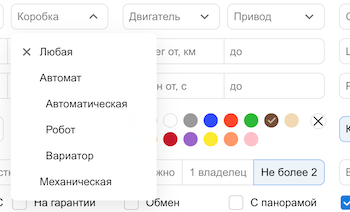

Создадим из данного признака два новых признака:
- коробка передач (автомат, механика)
- для автомата создадим признак (тип автомата).

In [42]:
# Создаем колонку transmission со значениями "автомат" и "механическая"
data['transmission'] = data.vehicleTransmission.copy()

data['transmission'].replace(['AUTOMATIC', 'ROBOT', 'VARIATOR',
                              'роботизированная', 'автоматическая', 'вариатор'], "автомат", inplace = True)
data['transmission'].replace(['MECHANICAL', 'механическая'], "механическая", inplace = True)

In [43]:
# Создаем колонку automate_type со значениями 'робот', 'автоматическая', 'вариатор' или 0 для "механическая"

data['automaticType'] = data.vehicleTransmission.copy()

data['automaticType'].replace(['AUTOMATIC', 'автоматическая'], "автоматическая", inplace = True)
data['automaticType'].replace(['ROBOT', 'роботизированная', ], "робот", inplace = True)
data['automaticType'].replace(['VARIATOR', 'вариатор'], "вариатор", inplace = True)
data['automaticType'].replace(['MECHANICAL', 'механическая'], 0, inplace = True)

In [44]:
# Проверим, какие значения получились
data['transmission'].unique()

array(['механическая', 'автомат', nan], dtype=object)

In [45]:
# Проверим, какие значения получились
data['automaticType'].unique()

array([0, 'автоматическая', 'робот', 'вариатор', nan], dtype=object)

In [46]:
# Добавляем в колонки на удаление обработаный признак
cols_removal.append('vehicleTransmission')

**color**

Цвет автомобиля.

In [47]:
# Посмотрим на представленные цвета
data.color.unique()

array(['040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый',
       'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый',
       'фиолетовый', 'золотистый', 'розовый'], dtype=object)

In [48]:
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный', 
              'FAFBFB': 'белый','97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый', 
              'C49648': 'бежевый', 'DEA522': 'золотистый','4A2197': 'фиолетовый' , 'FFD600': 'жёлтый', 
              'FF8649': 'оранжевый' , 'FFC0CB': 'розовый'}

data['color'].replace(to_replace=color_dict, inplace=True)

In [49]:
# Проверяем результат
data.color.unique()

array(['чёрный', 'красный', 'синий', 'серебристый', 'зелёный', 'белый',
       'серый', 'голубой', 'пурпурный', 'коричневый', 'бежевый',
       'золотистый', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype=object)

**driveSide**

Расположение руля

In [59]:
data.driveSide.unique()

array(['левый', 'правый', nan], dtype=object)

In [51]:
# Заменим анлоязычные значения на русские

data['driveSide'] = data['driveSide'].map({'RIGHT':'Правый', 'LEFT':'Левый'})

In [52]:
# уберем верхний регистр
data['driveSide'] = data['driveSide'].str.lower()

**tcp**

Оригинал ПТС

In [58]:
data.tcp.unique()

array(['оригинал', 'дубликат', nan], dtype=object)

In [54]:
# Заменим анлоязычные значения на русские
data['tcp'] = data['tcp'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})

In [55]:
# уберем верхний регистр
data['tcp'] = data['tcp'].str.lower()

**bodyType**

Тип кузова.

In [56]:
data.bodyType.value_counts()

Внедорожник 5 дв.                  31885
Седан                              30593
седан                              13147
внедорожник 5 дв.                  12228
Хэтчбек 5 дв.                       8668
                                   ...  
Седан 120                              1
Седан Gracia                           1
Универсал 5 дв. California             1
Пикап Полуторная кабина Rap Cab        1
Универсал 5 дв. XC                     1
Name: bodyType, Length: 192, dtype: int64

In [57]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях

data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())

### 3.6 Дубликаты

Определим количество дубликатов в данных в части train.

In [83]:
print("Количество дубликатов строк в train части датафрейма:",
      data[data.train == 1].duplicated().sum())

Количество дубликатов строк в train части датафрейма: 0


In [79]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace = True)

### 3.7 Анализ пропусков

### 3.8 Извлечение дополнительных признаков из данных

In [85]:
# Test

In [86]:
# Data

### Детальный анализ признаков

Список вопросов для детального анализа из предыдущих шагов:
- [ ] brand	- разобраться, что такое GREAT_WALL
- [ ] fuelType - разобраться, что такое универсал
- [ ] engineDisplacemen	- разобраться, какие значения, унифицировать и/или сгенерировать новые признаки
- [ ] description - кандидат на удаление, но можно извлечь новые признаки
- [ ] ownershipTime - извлечь длительность владения авто на момент сбора объявления
- [ ] numberOfDoors - разобраться с транспортом 0 дверей

### Анализ выбросов


### Анализ взаимосвязи признаков между собой


### Анализ взаимосвязи признаков с таргетом

### Выводы и идеи по генерации новых признаков

In [ ]:
train.dropna(subset=['productionDate', 'mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [ ]:
# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate',
           'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

In [ ]:
y = train['price']

## Label Encoding

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [ ]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
data

In [ ]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 5. Model 1. Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(
    tmp_train.groupby('engineDisplacement')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# 6. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [ ]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_baseline.model')

In [ ]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
np.log(y_train)

In [ ]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим точность возросла до 15%, а что будет на ЛБ?

# Model 3. Lazypredict


In [ ]:
pip install lazypredict

In [ ]:
import lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor

#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

# 7. Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing